In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 712kB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 2.2MB 24.2MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210311-cp37-none-any.whl size=58461 sha256=0798dcafb48c4ffb901f2a5800a7176b14a5f85f0537a9e6c4e61b69578e2c39
  Stored in directory: /root/.cache/pip/wheels/bc/cc/93/e011d6b86d91631d948f9bda94d60b82b51302192eb8a688c8
  Created wheel for iopath: filename=iopath-0.1.6-cp37-none-any.whl size=18269 sha256=3f60f909f997032223adc3d6fef69013ee60f25b3ff94fca1bd7c053f9696c18
  Stored in directory: /root/.cache/pip/wheels/ff/87/55/7513122394822977f993e1798bfebb46730d6183df8db7b283
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling 

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

| #Values | Names      | Description                                                                                                                |
|---------|------------|----------------------------------------------------------------------------------------------------------------------------|
| 1       | type       | Describes the type of object: 'Car', 'Van', 'Truck','Pedestrian', 'Person_sitting', 'Cyclist', 'Tram','Misc' or 'DontCare' |
| 1       | truncated  | Float from 0 (non-truncated) to 1 (truncated),                                                                             |
| 1       | occluded   | 0 = fully visible, 1 = partly occluded, 2 = largely occluded, 3 = unknown                                                  |
| 1       | alpha      | Observation angle                                                                                                          |
| 4       | bbox       | left, top, right, bottom pixel coordinates                                                                                 |
| 3       | dimensions | 3D object dimensions: height, width, length (in meters)                                                                    |
| 3       | location   | 3D object location x,y,z in camera coordinates (in meters)                                                                 |
| 1       | rotation_y | Rotation ry around Y-axis in camera coordinates [-pi..pi]                                                                  |
| 1       | score      | Only for results: Float, indicating confidence in detection, needed for p/r curves, higher is better.                      |

In [ ]:
Example:

Car 0.60 3 -2.42 0.00 185.93 214.05 348.86 1.56 1.57 4.37 -6.96 1.73 7.83 -3.13

# Register KITTI dataset

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

import os
import pandas as pd
from detectron2.structures import BoxMode

def get_kitti_dicts(kitti_dir):
  classes = ('Car', 'Van', 'Truck','Pedestrian', 'Person_sitting', 'Cyclist', 'Tram','Misc', 'DontCare')
  cols = ('type', 'truncated', 'occluded', 'alpha', 'left', 'top', 'right',
      'bottom', 'height', 'width', 'length', 'x', 'y', 'z', 'rot_y','score')

  record = {} #Dict with image info for the dataset

  dataset_dicts = []
  for idx in [7473]:
      img_path = os.path.join(kitti_dir, 'data_object_image_2', 'training', 'image_2', str(idx).zfill(6)+'.png')
      labels_path = os.path.join(kitti_dir, 'training', 'label_2', str(idx).zfill(6)+'.txt')
      
      height, width = cv2.imread(img_path).shape[:2]

      record = {}
      record["file_name"] = img_path
      record["image_id"] = idx
      record["height"] = height
      record["width"] = width

      objs = []

      dtf = pd.read_csv(labels_path, delimiter=' ', names=cols)     
      for i, row in dtf.iterrows():
          # Accessing all available info
          # obj = {
          # 'type': row.type,
          # 'truncated': row.truncated,
          # 'occluded': row.occluded,
          # 'alpha': row.alpha,
          # 'bbox': (row.left, row.top, row.right, row.bottom),
          # 'dims': (row.height, row.width, row.length),
          # 'pos': (row.x, row.y, row.z),
          # 'rot_y': row.rot_y,
          # 'score': row.score
          # }
          # objs.append(obj)

          # Add filters on truncated, occluded and maybe size?
          obj = {
            "bbox": [row.left, row.top, row.right, row.bottom],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": classes.index(row.type),
          }
          objs.append(obj)
      record["annotations"] = objs
      dataset_dicts.append(record)
      
  return dataset_dicts
  '''
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts
  '''

# get_kitti_dicts('/content/drive/MyDrive/Datasets/KITTI')

# for d in ["train", "val"]:
#     DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
#     MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
# balloon_metadata = MetadataCatalog.get("balloon_train")
DatasetCatalog.register("foo-kitti", lambda : get_kitti_dicts('/content/drive/MyDrive/Datasets/KITTI'))
MetadataCatalog.get("foo-kitti").set(thing_classes=('Car', 'Van', 'Truck','Pedestrian', 'Person_sitting', 'Cyclist', 'Tram','Misc', 'DontCare') )

kitti_metadata = MetadataCatalog.get("foo-kitti")

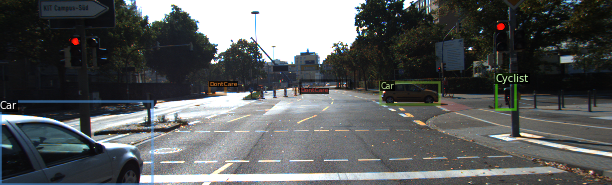

In [ ]:
kitti_metadata = MetadataCatalog.get("foo-kitti")
# Randomly visualize ds
dataset_dicts = get_kitti_dicts('/content/drive/MyDrive/Datasets/KITTI')
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=kitti_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Train
from detectron2.engine import DefaultTrainer
classes = ('Car', 'Van', 'Truck','Pedestrian', 'Person_sitting', 'Cyclist', 'Tram','Misc', 'DontCare')

mzoo_config_file = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(mzoo_config_file))
cfg.DATASETS.TRAIN = ("foo-kitti",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(mzoo_config_file)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/14 11:47:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:06, 24.6MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (10, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (10,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (36, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.


[03/14 11:47:52 d2.engine.train_loop]: Starting training from iteration 0
[03/14 11:47:55 d2.utils.events]:  eta: 0:00:43  iter: 19  total_loss: 3.412  loss_cls: 2.27  loss_box_reg: 0.8807  loss_rpn_cls: 0.216  loss_rpn_loc: 0.04033  time: 0.1568  data_time: 0.0103  lr: 4.9953e-06  max_mem: 1797M
[03/14 11:47:59 d2.utils.events]:  eta: 0:00:40  iter: 39  total_loss: 3.316  loss_cls: 2.17  loss_box_reg: 0.9088  loss_rpn_cls: 0.2279  loss_rpn_loc: 0.0415  time: 0.1569  data_time: 0.0022  lr: 9.9902e-06  max_mem: 1797M
[03/14 11:48:02 d2.utils.events]:  eta: 0:00:37  iter: 59  total_loss: 3.079  loss_cls: 1.959  loss_box_reg: 0.8893  loss_rpn_cls: 0.1952  loss_rpn_loc: 0.03903  time: 0.1571  data_time: 0.0022  lr: 1.4985e-05  max_mem: 1797M
[03/14 11:48:05 d2.utils.events]:  eta: 0:00:34  iter: 79  total_loss: 2.721  loss_cls: 1.63  loss_box_reg: 0.8796  loss_rpn_cls: 0.1508  loss_rpn_loc: 0.03605  time: 0.1573  data_time: 0.0023  lr: 1.998e-05  max_mem: 1797M
[03/14 11:48:08 d2.utils.eve

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

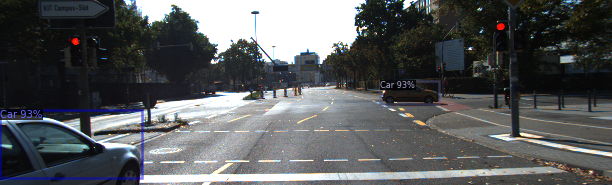

In [ ]:
# Rnadomly visualize results
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_kitti_dicts('/content/drive/MyDrive/Datasets/KITTI')
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=kitti_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("foo-kitti", ("bbox",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "foo-kitti")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/14 11:54:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/14 11:54:09 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[03/14 11:54:09 d2.data.common]: Serialized dataset takes 0.00 MiB
[03/14 11:54:09 d2.evaluation.evaluator]: Start inference on 1 images
[03/14 11:54:09 d2.evaluation.evaluator]: Inference done 1/1. 0.1166 s / img. ETA=0:00:00
[03/14 11:54:09 d2.evaluation.evaluator]: Total inference time: 0:00:00.160127 (0.160127 s / img per device, on 1 devices)
[03/14 11:54:09 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.116592 s / img per device, on 1 devices)
[03/14 11:54:09 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/14 11:54:09 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[03/14 11:54:09 d2.evaluation.coco_evaluation]: Ev